In [1]:
import os
import jCMIP as jc
Clist = jc.readList(('CMIP6listnew'))
from netCDF4 import Dataset
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy import stats as st
import cftime
import pandas as pd

#### Sea ice cover using siconc (%)

##### Compute sea ice cover for every model

In [42]:
#NESM3 excluded, since areacello is not included and in model data siconc is on different grid
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','UKESM1-0-LL']
ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
ENSar  = ['r2i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1',
           'r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
EXP    = 'historical'

#Change time to date
outfile = ('/home/users/jordi/section26data/' + totmod[6] + '_' + EXP + '_' + ENS[6] + '.nc')  #CNRM-CM6-1 has gregorian calendar, which is supported by python datetime objects
ncid    = Dataset(outfile,'r')
time    = ncid.variables['time'][-129::]
units   = ncid.variables['time'].units
cal     = ncid.variables['time'].calendar
ncid.close()

tdate   = cftime.num2pydate(time,units)

for i in range(len(totmod)):
    model   = Clist[totmod[i]]
    SCFiles = model.getFiles('siconc',EXP=EXP,ENS=ENS[i],vtype='SImon',gtype='gn')
    VFiles  = model.getFiles('vo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    
    if len(SCFiles) == 1:
        ncid = Dataset(SCFiles[0],'r')
        sc   = ncid.variables['siconc'][:]
        ncid.close()
        
    if 1 < len(SCFiles) < 4:
        ncid = Dataset(SCFiles[-1],'r')
        sc = ncid.variables['siconc'][:]
        ncid.close()
        
    if 8 < len(SCFiles) < 11:
        ncid = Dataset(SCFiles[-2],'r')
        sc = ncid.variables['siconc'][:]
        ncid.close()
        
        #Append multiple files to include needed historical period
        ncid = Dataset(SCFiles[-1],'r')
        sci  = ncid.variables['siconc'][:]
        sc   = np.append(sc,sci,axis=0)
        ncid.close()
    
    if len(SCFiles) == 33:
        ncid = Dataset(SCFiles[-3],'r')
        sc = ncid.variables['siconc'][:]
        ncid.close()
        
        for k in range(2):
            ncid = Dataset(SCFiles[-2+k],'r')
            sci  = ncid.variables['siconc'][:]
            sc   = np.append(sc,sci,axis=0)
            ncid.close()   
    
    if len(SCFiles) == 165:
        ncid = Dataset(SCFiles[-12],'r')
        sc = ncid.variables['siconc'][:]
        ncid.close()
        
        for k in range(11):
            ncid = Dataset(SCFiles[-11+k],'r')
            sci  = ncid.variables['siconc'][:]
            sc   = np.append(sc,sci,axis=0)
            ncid.close() 
                        
    ncid = Dataset(VFiles[-1],'r')
    if model.Oreg:
        lon  = ncid.variables[model.Olon][:]
        lat  = ncid.variables[model.Olat][:]
        lon,lat = np.meshgrid(lon,lat)
    else:
        lon  = ncid.variables[model.Olon][:,:]
        lat  = ncid.variables[model.Olat][:,:]
    ncid.close()

    #Get area of grid cells
    AFiles  = model.getFiles('areacello',EXP='*',ENS=ENSar[i],vtype='Ofx',gtype='gn')
    ncid = Dataset(AFiles[0],'r')
    area = ncid.variables['areacello'][:]
    ncid.close() 
    
    #Find index of 40N
    alat = 40
    mlat = np.mean(lat,axis=1)
    ilat = np.argmin(np.abs(mlat-alat))
    
    #Flip grid for MPI models
    if model.name in ['MPI-ESM1-2-HR','MPI-ESM1-2-LR']:
        alat = 40
        mlat = np.mean(np.flip(lat,axis=0),axis=1)
        ilat = np.argmin(np.abs(mlat-alat))
        sc   = np.flip(sc,axis=1)
        area = np.flip(area,axis=0)
    
    #Get mask file
    mesh_mask = ('/home/users/jordi/mesh_masks/' + model.name + '_mesh_mask.nc')
    ncid = Dataset(mesh_mask,'r')
    tmask = np.squeeze(ncid.variables['tmask'][:,:,:,:])
    dxt = ncid.variables['dxt'][:,:]
    dyt = ncid.variables['dyt'][:,:]
    ncid.close()
    
    time = 129       
    sch = sc[-129::,ilat::,:]
    schnew = sch
    
    #Mask information is not included when append function is used, thus we need to multiply several models by their mask files
    if model.name in ['EC-Earth3','MPI-ESM1-2-HR','MPI-ESM1-2-LR']:
        schnew = np.zeros(np.shape(sch[:,:,1:-1]))
        for t in range(time):
            schnew[t,:,:] = sch[t,:,1:-1]*tmask[0,ilat::,:]
    elif model.name == 'HadGEM3-GC31-MM':
        for t in range(time):
            schnew[t,:,:] = sch[t,:,:]*tmask[0,ilat::,:]
    
    #Correct for mismatch in shape (i.e. halo points)
    if model.name in ['CMCC-CM2-SR5','CMCC-ESM2']:
        area = area[0:-1,1:-1]
    elif model.name in ['EC-Earth3','MPI-ESM1-2-HR','MPI-ESM1-2-LR']:
        area = area[:,1:-1]
    
    #Compute sea ice area
    scarea = np.zeros(np.shape(area[ilat::,:]))
    cover = np.zeros(time)
    for j in range(time):
        scarea = schnew[j,:,:]*area[ilat::,:]/100          #Divide by 100 since siconc is in percentage
        cover[j] = np.nansum(scarea[:,:])
    
    if i == 0:
        cover_df = pd.DataFrame(data=cover,columns=[totmod[i]],index=tdate)
    else:
        cover_df[totmod[i]] = cover

cover_df.to_pickle('/home/users/jordi/si_cover.pkl')        
print('Done!')

/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/numpy/ma/core.py:1015: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/users/jmecking001/miniconda3/envs/jordi_2021/lib/python3.7/site-packages/ipykernel_launcher.py:81: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


ValueError: operands could not be broadcast together with shapes (179,320) (87,360) 

##### Plot timeseries of every model

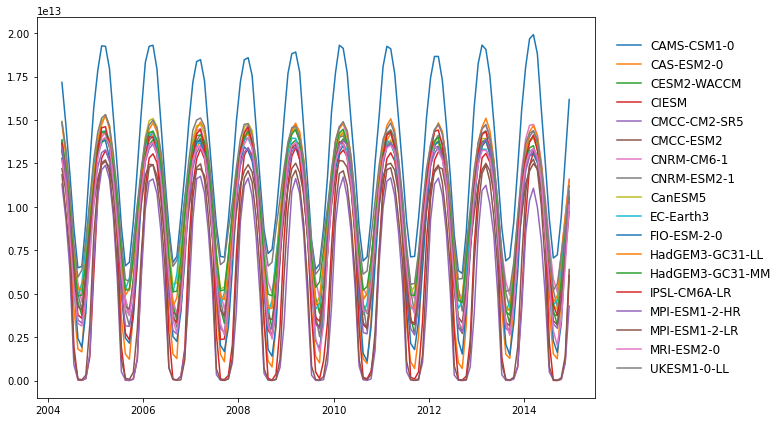

In [124]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','UKESM1-0-LL']

cover_df = pd.read_pickle('si_cover.pkl')

plt.figure(1,figsize=(10,7))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','lightgreen'])
for i in range (len(totmod)):
    plt.plot(tdate,cover_df[totmod[i]],label=str(totmod[i]))
    plt.legend(loc='center left',bbox_to_anchor=(1.02, 0.5),prop={'size': 12},frameon=False)

##### Relate ΔMOC to sea ice extent and seasonality

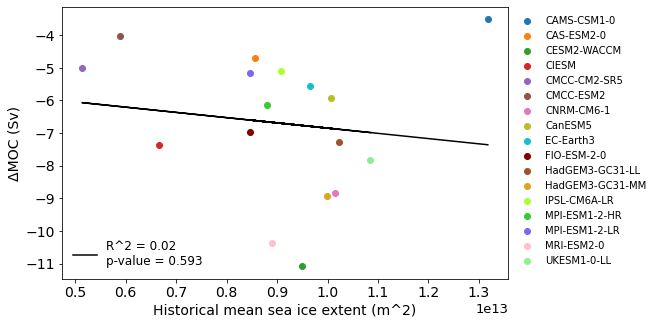

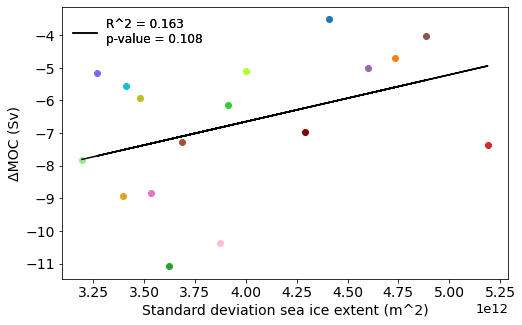

In [2]:
totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','UKESM1-0-LL']
#'CNRM-ESM2-1'

idx = np.arange(17)
mod_mean = pd.read_pickle('diff_mod.pkl')
cover_df = pd.read_pickle('si_cover.pkl')
mod_meandl = mod_mean.drop('NESM3',axis=0)    #Exclude NESM3
mod_meandl = mod_meandl.set_index(idx)
cover_df   = cover_df.drop('CNRM-ESM2-1',axis=1)

#Plot diff MOC vs sea ice extent
fig,ax = plt.subplots(figsize=(8,5))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','lightgreen'])
for i in range(len(totmod)):
    scat = plt.scatter(np.nanmean(cover_df,axis=0)[i],mod_meandl['MOC'][i],label=str(totmod[i]))
    plt.legend(handles=[scat],bbox_to_anchor=(1.0,1.0),frameon=False)
plt.xlabel('Historical mean sea ice extent (m^2)',fontsize=14)
plt.ylabel('ΔMOC (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_offset_text().set_fontsize(13)

#Add linear regression
slope, intercept, rvalue, pvalue, stderr = st.linregress(np.nanmean(cover_df,axis=0),mod_meandl['MOC'])
lreg, = plt.plot(np.nanmean(cover_df,axis=0),slope*np.nanmean(cover_df,axis=0)+intercept,color='k')
leg1 = plt.legend([lreg],['R^2 = ' + str(round(rvalue**2,3)) + '\np-value = ' + str(round(pvalue,3))],prop={'size': 12},frameon=False)
plt.gca().add_artist(leg1)
plt.legend(bbox_to_anchor=(1.0,1.0),frameon=False)

#Plot diff MOC vs sea ice seasonality
fig,ax = plt.subplots(figsize=(8,5))
plt.gca().set_prop_cycle(color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:olive','tab:cyan','maroon','sienna','goldenrod','greenyellow','limegreen','mediumslateblue','pink','lightgreen'])
for i in range(len(totmod)):
    scat = plt.scatter(np.nanstd(cover_df,axis=0)[i],mod_meandl['MOC'][i],label=str(totmod[i]))
    plt.legend(handles=[scat],loc='lower center',bbox_to_anchor=(0.5, 1.1),ncol = 5,prop={'size': 14},frameon=False)
plt.xlabel('Standard deviation sea ice extent (m^2)',fontsize=14)
plt.ylabel('ΔMOC (Sv)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.xaxis.get_offset_text().set_fontsize(13)

#Add linear regression
slope, intercept, rvalue, pvalue, stderr = st.linregress(np.nanstd(cover_df,axis=0),mod_meandl['MOC'])
lreg, = plt.plot(np.nanstd(cover_df,axis=0),slope*np.nanstd(cover_df,axis=0)+intercept,color='k')
leg1 = plt.legend([lreg],['R^2 = ' + str(round(rvalue**2,3)) + '\np-value = ' + str(round(pvalue,3))],prop={'size': 12},frameon=False)
plt.gca().add_artist(leg1)
#plt.legend(loc='lower center',bbox_to_anchor=(0.5, 1.1),ncol = 5,prop={'size': 14},frameon=False)

##### 2D plot of sea ice cover minimum and maximum (CMCC-ESM2)

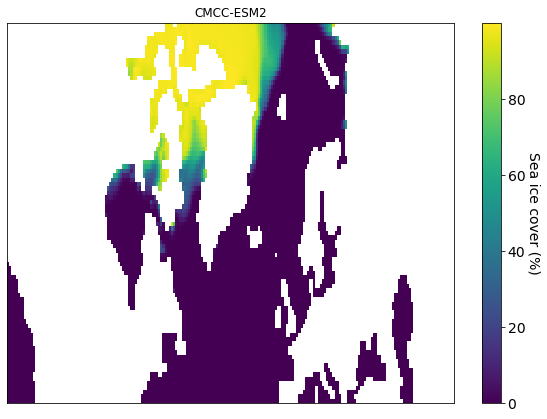

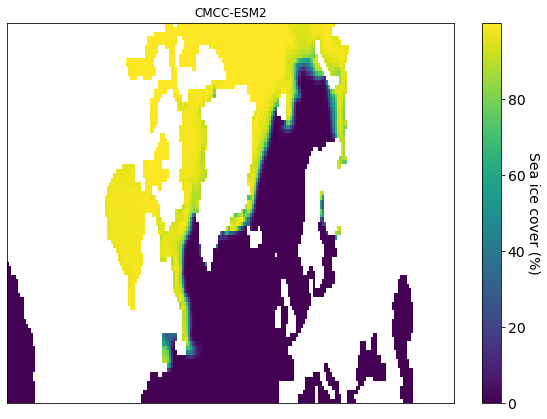

In [27]:
totmod = ['CMCC-ESM2']
ENS    = ['r1i1p1f1']
EXP    = 'historical'

for i in range(len(totmod)): 
    model   = Clist[totmod[i]]
    SCFiles = model.getFiles('siconc',EXP=EXP,ENS=ENS[i],vtype='SImon',gtype='gn')
    VFiles  = model.getFiles('vo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    
    ncid = Dataset(SCFiles[0],'r')
    sc   = ncid.variables['siconc'][:]
    ncid.close()
    
    ncid = Dataset(VFiles[-1],'r')
    if model.Oreg:
        lon  = ncid.variables[model.Olon][:]
        lat  = ncid.variables[model.Olat][:]
        lon,lat = np.meshgrid(lon,lat)
    else:
        lon  = ncid.variables[model.Olon][:,:]
        lat  = ncid.variables[model.Olat][:,:]
    ncid.close()
    
    alat = 40
    mlat = np.mean(lat,axis=1)
    ilat = np.argmin(np.abs(mlat-alat))
    
    #Find min and max sea ice cover
    scsum = np.nansum(np.nansum(sc[-129::,:,:],axis=-1),axis=-1)
    tmin = np.nanargmin(scsum)
    tmax = np.nanargmax(scsum)
    
    plt.figure(i,figsize=(10,7))
    plt.pcolormesh(sc[tmin,ilat::,150::])
    plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)
    plt.title(str(totmod[i]))
    cbar = plt.colorbar()
    cbar.set_label('Sea ice cover (%)',rotation=270,labelpad=15,fontsize=14)
    cbar.ax.tick_params(labelsize=14)

    plt.figure(i+1,figsize=(10,7))
    plt.pcolormesh(sc[tmax,ilat::,150::])
    plt.tick_params(axis='both',which='both',bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)
    plt.title(str(totmod[i]))
    cbar = plt.colorbar()
    cbar.set_label('Sea ice cover (%)',rotation=270,labelpad=15,fontsize=14)
    cbar.ax.tick_params(labelsize=14)

#### Check files

In [2]:
#totmod =  ['CAMS-CSM1-0','CAS-ESM2-0','CESM2-WACCM','CIESM','CMCC-CM2-SR5','CMCC-ESM2','CNRM-CM6-1','CNRM-ESM2-1','CanESM5','EC-Earth3','FIO-ESM-2-0',
#            'HadGEM3-GC31-LL','HadGEM3-GC31-MM','IPSL-CM6A-LR','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NESM3','UKESM1-0-LL']
#ENS    =  ['r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f3',
#           'r1i1p1f3','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
#ENSar  = ['r2i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2','r2i1p1f2','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1',
#           'r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f1','r1i1p1f2']
#EXP    = 'historical'

totmod =  ['NESM3']
ENS    =  ['r1i1p1f1']
EXP    = 'historical'

for i in range(len(totmod)):
    model   = Clist[totmod[i]]
    SCFiles = model.getFiles('siconc',EXP=EXP,ENS=ENS[i],vtype='SImon',gtype='gn')
    ncid = Dataset(SCFiles[0],'r')
    sc   = ncid.variables['siconc'][-1]
    lat    = ncid.variables['lat'][:]
    lon    = ncid.variables['lon'][:]
    x = list(ncid.variables)
    ncid.close()
    #print(str(totmod[i]) + ' - ' + str(np.shape(SCFiles)))
    print(str(totmod[i]) + ' - ' + str(np.shape(sc)))
    
    VFiles = model.getFiles('vo',EXP=EXP,ENS=ENS[i],vtype='Omon',gtype='gn')
    ncid = Dataset(VFiles[0],'r')
    vo   = ncid.variables['vo'][-1]
    ncid.close()
    print(str(totmod[i]) + ' - ' + str(np.shape(SCFiles)))
    print(str(totmod[i]) + ' - ' + str(np.shape(vo)))
    
    AFiles  = model.getFiles('areacelli',EXP='*',ENS=ENS[i],vtype='*',gtype='gn')
    print(str(totmod[i]) + ' - ' + str(np.shape(AFiles)))   
    print(model.Imeshmask)

NESM3 - (384, 320)
NESM3 - (1,)
NESM3 - (46, 292, 362)
NESM3 - (0,)
unknown
